# Bedrock AgentCore Memory Checkpointer Walkthrough

This sample notebook walks through setup and usage of the Bedrock AgentCore Memory Checkpointer with LangGraph. This approach enables saving of conversations and state data to the Memory API for persistent storage, fault tolerance, and human-in-the-loop workflows.

### Setup
For this notebook you will need:
1. An Amazon Web Services development account
2. Bedrock Model Access (i.e. Claude 3.7 Sonnet)
3. An AgentCore Memory Resource configured (see below section for details)

### AgentCore Memory Resource

Either in the AWS developer portal or using the boto3 library you must create an [AgentCore Memory Resource](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agentcore-control/client/create_memory.html). For just using the `AgentCoreMemorySaver` checkpointer in this notebook, you do not need to specify any specific long-term memory strategies. However, it may be beneficial to supplement this approach with the `AgentCoreMemoryStore` to save and extract conversational insights, so you may want to enable strategies for that use case.

Once you have the Memory enabled and in a `ACTIVE` state, take note of the `memoryId`, we will need it later.

In [ ]:
%pip install langchain

In [10]:
# Import LangGraph and LangChain components
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langgraph.prebuilt import create_react_agent

In [11]:
# Import the AgentCoreMemorySaver that we will use as a checkpointer
from langgraph_checkpoint_aws import AgentCoreMemorySaver

import logging
logging.getLogger().setLevel(logging.DEBUG)

## AgentCore Memory Configuration
- `REGION` corresponds to the AWS region that your resources are present in, these are passed to the `AgentCoreMemorySaver`.
- `MEMORY_ID` corresponds to your top level AgentCore Memory resource. Within this resource we will store checkpoints for multiple actors and sessions
- `MODEL_ID` this is the bedrock model that will power our LangGraph agent through Bedrock Converse.

We will use the `MEMORY_ID` and any additional boto3 client keyword args (in our case, `REGION`) to instantiate our checkpointer.

In [22]:
REGION = "us-west-2"
MEMORY_ID = "YOUR_MEMORY_ID"
MODEL_ID = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"

# Initialize checkpointer for state persistence
checkpointer = AgentCoreMemorySaver(MEMORY_ID, region_name=REGION)

# Initialize LLM
llm = init_chat_model(MODEL_ID, model_provider="bedrock_converse", region_name=REGION)

## Define our tools

For this demo notebook we will only give our agent access to two simple tools, adding and multiplying.

In [13]:
@tool
def add(a: int, b: int):
    """Add two integers and return the result"""
    return a + b


@tool
def multiply(a: int, b: int):
    """Multiply two integers and return the result"""
    return a * b


tools = [add, multiply]

## Build our LangGraph agent graph

Our agent will be built with the `create_react_agent` builder. It just has a few simple nodes, mainly a chatbot node and a tool node. This will enable our chatbot to use the add and multiply tools as much as it needs and then return a response. We will visualize this graph below.

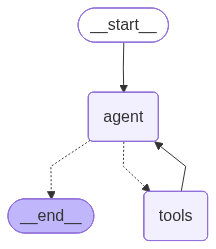

In [14]:
graph = create_react_agent(
    model=llm,
    tools=tools,
    prompt="You are a helpful assistant",
    checkpointer=checkpointer,
)

graph

## IMPORTANT: Input and Config

### Graph Invoke Input
We only need to pass the newest user message in as an argument `inputs`. This could include other state variables too but for the simple `create_react_agent`, messages are all that's required.

### LangGraph RuntimeConfig
In LangGraph, config is a `RuntimeConfig` that contains attributes that are necessary at invocation time, for example user IDs or session IDs. For the `AgentCoreMemorySaver`, `thread_id` and `actor_id` must be set in the config. For instance, your AgentCore invocation endpoint could assign this based on the identity or user ID of the caller. Additional documentation here: [https://langchain-ai.github.io/langgraphjs/how-tos/configuration/](https://langchain-ai.github.io/langgraphjs/how-tos/configuration/)



In [23]:
config = {
    "configurable": {
        "thread_id": "session-1", # REQUIRED: This maps to Bedrock AgentCore session_id under the hood
        "actor_id": "react-agent-1", # REQUIRED: This maps to Bedrock AgentCore actor_id under the hood
    }
}

inputs = {"messages": [{"role": "user", "content": "What is 1337 times 515321? Then add 412 and return the value to me."}]}

### Run the agent

In [17]:
for chunk in graph.stream(inputs, stream_mode="updates", config=config):
    print(chunk)

{'agent': {'messages': [AIMessage(content=[{'type': 'text', 'text': "I'll help you calculate this step by step using the available tools.\n\nFirst, I'll multiply 1337 by 515321, and then add 412 to the result."}, {'type': 'tool_use', 'name': 'multiply', 'input': {'a': 1337, 'b': 515321}, 'id': 'tooluse_8NTeZaI6SRWVrWS3msurvQ'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'cb32ee7b-35c8-42f4-b28d-ab81611f57f3', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 23 Sep 2025 00:51:44 GMT', 'content-type': 'application/json', 'content-length': '563', 'connection': 'keep-alive', 'x-amzn-requestid': 'cb32ee7b-35c8-42f4-b28d-ab81611f57f3'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [4900]}, 'model_name': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0'}, id='run--8fa9fc8d-4491-4a79-bf9e-8921f710b1a4-0', tool_calls=[{'name': 'multiply', 'args': {'a': 1337, 'b': 515321}, 'id': 'tooluse_8NTeZaI6SRWVrWS3msurvQ', 'type': 'tool_call'}], 

## Inspect the current state with AgentCoreMemory

Under the hood when you call `graph.get_state(config)` it calls the checkpointer to retrieve the latest checkpoint saved for our actor and session. We can take a look at the values saved at this point in the conversation from `messages`.

In [18]:
for message in graph.get_state(config).values.get("messages"):
    print(f"{message.type}: {message.text()}")
    print("=========================================")

human: What is 1337 times 515321? Then add 412 and return the value to me.
ai: I'll help you calculate this step by step using the available tools.

First, I'll multiply 1337 by 515321, and then add 412 to the result.
tool: 688984177
ai: Now I'll add 412 to this result:
tool: 688984589
ai: The result of multiplying 1337 by 515321 and then adding 412 is 688,984,589.


## Look at a previous checkpoints during execution
Using the `graph.get_state_history(config)` we will see the checkpoints that were saved, then inspect a previous checkpoint's values for `messages`. Checkpoints are listed so the most recent checkpoints appear first.

In [19]:
for checkpoint in graph.get_state_history(config):
    print(
        f"(Checkpoint ID: {checkpoint.config['configurable']['checkpoint_id']}) # of messages in state: {len(checkpoint.values.get('messages'))}"
    )

(Checkpoint ID: 1f098177-c42d-6f60-8005-354f815e0136) # of messages in state: 6
(Checkpoint ID: 1f098177-b654-6baa-8004-a8b0f118635a) # of messages in state: 5
(Checkpoint ID: 1f098177-b647-6b76-8003-6283dc729a79) # of messages in state: 4
(Checkpoint ID: 1f098177-9e9b-670c-8002-588abfad5280) # of messages in state: 3
(Checkpoint ID: 1f098177-9e89-628c-8001-2bc2df91b7a3) # of messages in state: 2
(Checkpoint ID: 1f098177-6d2f-6fce-8000-6268b3fc0a3c) # of messages in state: 1
(Checkpoint ID: 1f098177-6d20-6a7e-bfff-c58a1ddceda6) # of messages in state: 0


## Continue the conversation
By using the same config with our session and actor from before, we can continue the conversation by invoking our LangGraph agent with a new invocation state. The checkpointer in the background will take care of loading in context so that all the previous messages from the first interaction are loaded in.

In [20]:
inputs = {"messages": [{"role": "user", "content": "What were the first calculations I asked you to do?"}]}

for chunk in graph.stream(inputs, stream_mode="updates", config=config):
    print(chunk)

{'agent': {'messages': [AIMessage(content='The first calculations you asked me to do were:\n1. Multiply 1337 by 515321\n2. Add 412 to the result of the multiplication\n\nSpecifically, I calculated 1337 × 515321 = 688,984,177, and then added 412 to get the final answer of 688,984,589.', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '4dc65f04-85c5-4eb7-8139-1f852c3709bc', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 23 Sep 2025 00:52:08 GMT', 'content-type': 'application/json', 'content-length': '557', 'connection': 'keep-alive', 'x-amzn-requestid': '4dc65f04-85c5-4eb7-8139-1f852c3709bc'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [2033]}, 'model_name': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0'}, id='run--b19686f9-8c7d-4950-91e2-7c9a1bb5534d-0', usage_metadata={'input_tokens': 749, 'output_tokens': 81, 'total_tokens': 830, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}})]}}


## Start a new chat by using a new session ID

By providing a new thread_id, a new conversation will be started (while still persisting the old conversation in AgentCore Memory).

In [21]:
config = {
    "configurable": {
        "thread_id": "session-2", # New session ID
        "actor_id": "react-agent-1", # Same Actor ID
    }
}

inputs = {"messages": [{"role": "user", "content": "What values did I ask you to multiply and add?"}]}
for chunk in graph.stream(inputs, stream_mode="updates", config=config):
    print(chunk)

{'agent': {'messages': [AIMessage(content="I don't see that you've asked me to multiply or add any specific values yet. While I have tools available to perform multiplication and addition, you haven't provided any numbers for me to work with.\n\nWould you like me to multiply or add some numbers? If so, please provide the values you'd like me to use.", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '8ddf83ff-6536-4d41-b6b1-9763a1085fe2', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 23 Sep 2025 00:52:21 GMT', 'content-type': 'application/json', 'content-length': '623', 'connection': 'keep-alive', 'x-amzn-requestid': '8ddf83ff-6536-4d41-b6b1-9763a1085fe2'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [2118]}, 'model_name': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0'}, id='run--052bbac2-e944-4adf-8ff5-24263d10c209-0', usage_metadata={'input_tokens': 470, 'output_tokens': 70, 'total_tokens': 540, 'input_token_details': {'cac

## Wrapping Up

As you can see, the AgentCore checkpointer is very powerful for persisting conversational and graph state in the background. For more information, check out the official AgentCore Memory documentation here: https://docs.aws.amazon.com/bedrock-agentcore/latest/devguide/memory.html